# Linear basis function models with PyMC4

The following is a PyMC4 implementation of [Bayesian regression with linear basis function models](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/master/bayesian_linear_regression.ipynb). PyMC4 is still in an early state of development (an alpha release is available at the time of writing this notebook) i.e. the following code may break with future PyMC4 releases but I'll try to it keep up to date. A corresponding PyMC3 implementation is available [here](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/master/bayesian_linear_regression_pymc3.ipynb).

In [1]:
import logging
import pymc4 as pm
import numpy as np
import arviz as az

import tensorflow as tf
import tensorflow_probability as tfp

print(pm.__version__)
print(tf.__version__)
print(tfp.__version__)

# Mute Tensorflow warnings ...
logging.getLogger('tensorflow').setLevel(logging.ERROR)

4.0a2
2.2.0-dev20200414
0.10.0-dev20200414



## Introduction to PyMC4

PyMC4 uses [Tensorflow Probability](https://www.tensorflow.org/probability) (TFP) as backend and PyMC4 random variables are wrappers around TFP distributions. Models must be defined as [generator](https://docs.python.org/3/glossary.html#term-generator) functions, using a `yield` keyword for each random variable. PyMC4 uses [coroutines](https://www.python.org/dev/peps/pep-0342/) to interact with the generator to get access to random variables. Depending on the context, it may sample values from random variables, compute log probabilities of observed values, ... and so on. Details are covered in the [PyMC4 design guide](https://github.com/pymc-devs/pymc4/blob/master/notebooks/pymc4_design_guide.ipynb). Model generator functions must be decorated with ` @pm.model` as shown in the following trivial example:

In [2]:
@pm.model
def model(y):
    x = yield pm.Normal('x', loc=0, scale=10)
    y = yield pm.Normal('y', loc=x, scale=1, observed=y)

`pm.sample()` samples from the posterior using NUTS. Samplers other than NUTS or variational inference methods are not implemented yet.

In [3]:
y = np.random.randn(30) + 3

trace = pm.sample(model(y), num_chains=3)
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

The returned `trace` object is an ArviZ [`InferenceData`](https://arviz-devs.github.io/arviz/notebooks/XarrayforArviZ.html) object. It contains posterior samples, observed data and sampler statistics. The posterior distribution over `x` can be displayed with:

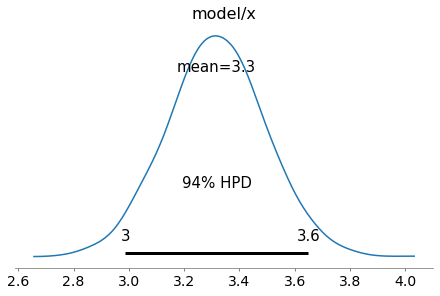

In [4]:
az.plot_posterior(trace, var_names=['model/x']);

Models can also be nested i.e. used like other PyMC4 random variables.

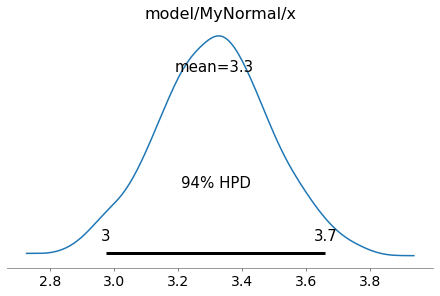

In [5]:
@pm.model
def MyNormal(name, loc=0, scale=10):
    x = yield pm.Normal(name, loc=loc, scale=scale)
    return x

@pm.model
def model(y):
    x = yield MyNormal('x')
    y = yield pm.Normal('y', loc=x, scale=1, observed=y)
    
trace = pm.sample(model(y), num_chains=3)
az.plot_posterior(trace, var_names=['model/MyNormal/x']);    

## Linear basis function models

I introduced regression with linear basis function models in a [previous article](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/master/bayesian_linear_regression.ipynb). To recap, a linear regression model is a linear function of the parameters but not necessarily of the input. Input $x$ can be expanded with a set of non-linear basis functions $\phi_j(x)$, where $(\phi_1(x), \dots, \phi_M(x))^T = \boldsymbol\phi(x)$, for modeling a non-linear relationship between input $x$ and a function value $y$.

$$
y(x, \mathbf{w}) = w_0 + \sum_{j=1}^{M}{w_j \phi_j(x)} = w_0 + \mathbf{w}_{1:}^T \boldsymbol\phi(x) \tag{1}
$$

For simplicity I'm using a scalar input $x$ here. Target variable $t$ is given by the deterministic function $y(x, \mathbf{w})$ and Gaussian noise $\epsilon$.

$$
t = y(x, \mathbf{w}) + \epsilon \tag{2}
$$

Here, we can choose between polynomial and Gaussian basis functions for expanding input $x$. 

In [6]:
from functools import partial
from scipy.stats import norm

def polynomial_basis(x, power):
    return x ** power

def gaussian_basis(x, mu, sigma):
    return norm(loc=mu, scale=sigma).pdf(x).astype(np.float32)

def _expand(x, bf, bf_args):
    return np.stack([bf(x, bf_arg) for bf_arg in bf_args], axis=1)

def expand_polynomial(x, degree=3):
    return _expand(x, bf=polynomial_basis, bf_args=range(1, degree + 1))

def expand_gaussian(x, mus=np.linspace(0, 1, 9), sigma=0.3):
    return _expand(x, bf=partial(gaussian_basis, sigma=sigma), bf_args=mus)

# Choose between polynomial and Gaussian expansion
# (by switching the comment on the following two lines)
expand = expand_polynomial
#expand = expand_gaussian

For example, to expand two input values `[0.5, 1.5]` into a polynomial design matrix of degree `3` we can use

In [7]:
expand_polynomial(np.array([0.5, 1.5]), degree=3)

array([[0.5  , 0.25 , 0.125],
       [1.5  , 2.25 , 3.375]])

The power of `0` is omitted here and covered by a $w_0$ in the model.

## Example dataset

The example dataset consists of `N` noisy samples from a sinusoidal function `f`.

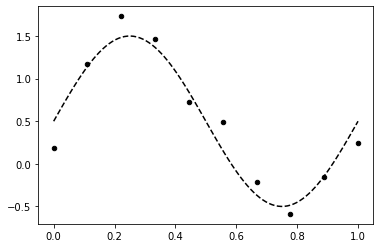

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

from bayesian_linear_regression_util import (
    plot_data, 
    plot_truth
)

def f(x, noise=0):
    """Sinusoidal function with optional Gaussian noise."""
    return 0.5 + np.sin(2 * np.pi * x) + np.random.normal(scale=noise, size=x.shape)

# Number of samples
N = 10

# Constant noise 
noise = 0.3

# Noisy samples 
x = np.linspace(0, 1, N, dtype=np.float32)
t = f(x, noise=noise)

# Noise-free ground truth 
x_test = np.linspace(0, 1, 100).astype(np.float32)
y_true = f(x_test)

plot_data(x, t)
plot_truth(x_test, y_true)

## Implementation with PyMC4

### Model definition

The model definition directly follows from Eq. $(1)$ and Eq. $(2)$ with normal priors over parameters. The size of parameter vector `w_r` ($\mathbf{w}_{1:}$ in Eq. $(1)$) is determined by the number of basis functions and set via the `batch_stack` parameter. With the above default settings, it is 3 for polynomial expansion and 9 for Gaussian expansion.

In [9]:
import tensorflow as tf

@pm.model
def model(Phi, t, sigma=noise):
    """Linear model generator.
    
    Args:
    - Phi: design matrix (N,M)
    - t: noisy target values (N,)
    - sigma: known noise of t
    """

    w_0 = yield pm.Normal(name='w_0', loc=0, scale=10)
    w_r = yield pm.Normal(name='w_r', loc=0, scale=10, batch_stack=Phi.shape[1])
    
    mu = w_0 + tf.tensordot(w_r, Phi.T, axes=1)
    
    yield pm.Normal(name='t_obs', loc=mu, scale=sigma, observed=t)

### Inference

Tensorflow will automatically run inference on a GPU if available. With the current version of PyMC4, inference on a GPU is quite slow compared to a multi-core CPU (need to investigate that in more detail). To enforce inference on a CPU set environment variable `CUDA_VISIBLE_DEVICES` to an empty value. There is no progress bar visible yet during sampling but the following shouldn't take longer than a 1 minute.

In [10]:
trace = pm.sample(model(expand(x), t), num_chains=3, burn_in=100, num_samples=1000)

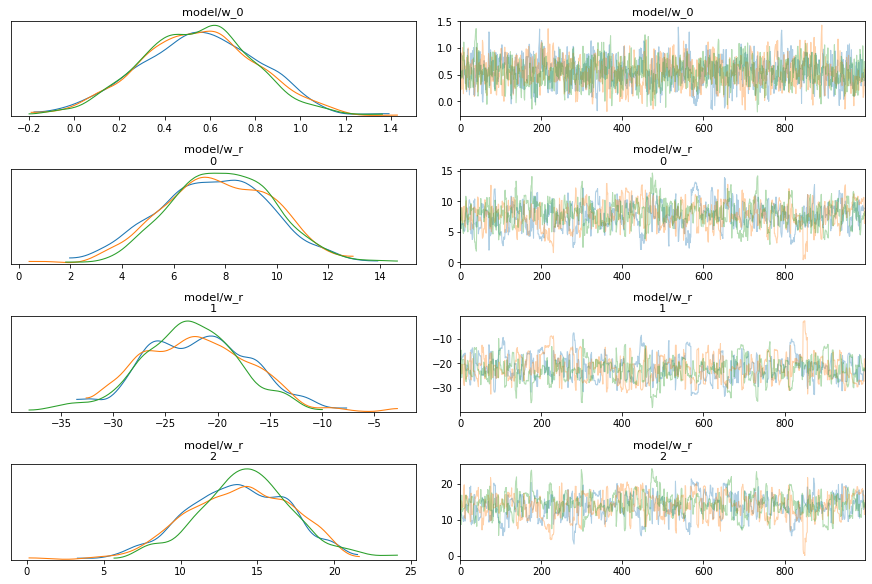

In [11]:
az.plot_trace(trace);

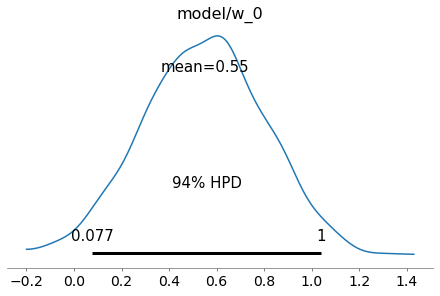

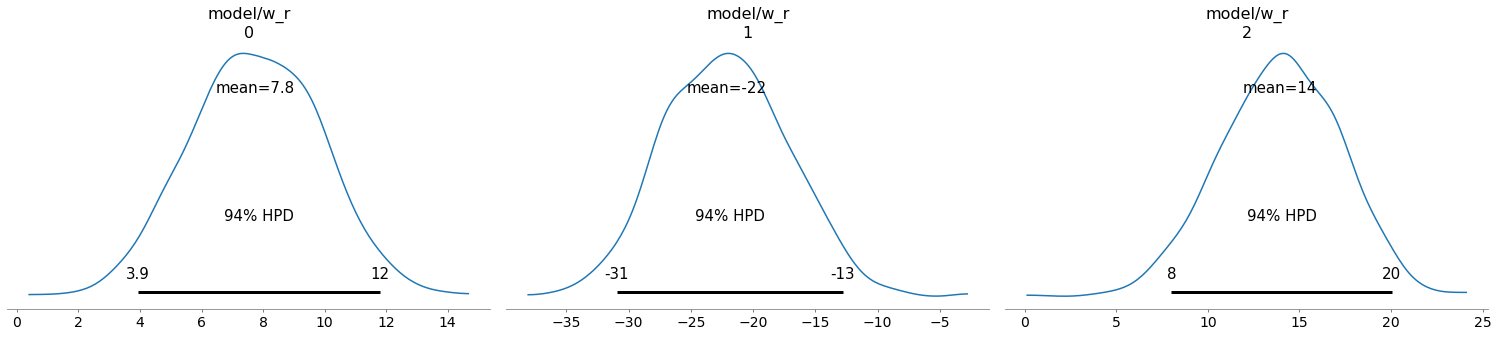

In [12]:
az.plot_posterior(trace, var_names="model/w_0");
az.plot_posterior(trace, var_names="model/w_r");

### Prediction

To obtain posterior predictive samples for a test set `x_test` we simply call the model generator function again with the expanded test set. This is a nice improvement over PyMC3 which required to setup a shared Theano variable for setting test set values. Target values are ignored during predictive sampling, only the shape of the target array `t` matters.

In [13]:
draws_posterior = pm.sample_posterior_predictive(model(expand(x_test), t=np.zeros_like(x_test)), trace, inplace=False)
draws_posterior.posterior_predictive

<xarray.Dataset>
Dimensions:            (chain: 3, draw: 1000, model/t_obs_dim_0: 100)
Coordinates:
  * chain              (chain) int64 0 1 2
  * draw               (draw) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * model/t_obs_dim_0  (model/t_obs_dim_0) int64 0 1 2 3 4 5 ... 95 96 97 98 99
Data variables:
    model/t_obs        (chain, draw, model/t_obs_dim_0) float32 0.62803966 ... -0.10609433
Attributes:
    created_at:     2020-04-22T05:50:53.606431
    arviz_version:  0.7.0

The predictive mean and standard deviation is obtained by averaging over chains (axis `0`) and predictive samples (axis `1`) for each of the 100 data points in `x_test` (axis `2`).

In [14]:
predictive_samples = draws_posterior.posterior_predictive.data_vars['model/t_obs'].values

m = np.mean(predictive_samples, axis=(0, 1))
s = np.std(predictive_samples, axis=(0, 1))

These statistics can be used to plot model predictions and their uncertainties (together with the ground truth and the noisy training dataset).

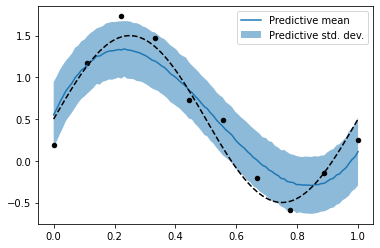

In [15]:
plt.fill_between(x_test, m + s, m - s, alpha = 0.5, label='Predictive std. dev.')
plt.plot(x_test, m, label='Predictive mean');

plot_data(x, t)
plot_truth(x_test, y_true, label=None)

plt.legend();

Try running the example again with Gaussian expansion i.e. setting `expand = expand_gaussian` and see how it compares to polynomial expansion. Also try running with a different number of basis functions by overriding the default arguments of `expand_polynomial` and `expand_gaussian`. You can find more PyMC4 examples in the [notebooks](https://github.com/pymc-devs/pymc4/tree/master/notebooks) diretory of the PyMC4 project.